In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

yolo_model_path = "/content/drive/MyDrive/tree_enum_model/resume_training/weights/best.pt"
yolo_model = YOLO(yolo_model_path)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import files
from PIL import Image
import numpy as np
import cv2

uploaded = files.upload()

# get filename
filename = next(iter(uploaded))
img = Image.open(filename)
img_np = np.array(img)


Saving image_498_JPG.rf.222759fae58a9c5d44f3736302336111.jpg to image_498_JPG.rf.222759fae58a9c5d44f3736302336111.jpg



0: 384x640 5 Not Trees, 14 Trees, 869.2ms
Speed: 5.0ms preprocess, 869.2ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Trees detected: 19


(np.float64(-0.5), np.float64(4031.5), np.float64(2267.5), np.float64(-0.5))

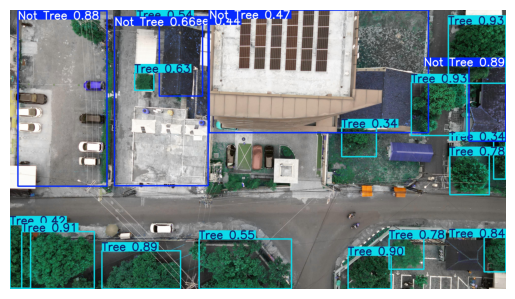

In [ ]:
results = yolo_model(img_np)
boxes = results[0].boxes.xyxy.cpu().numpy()  # (x1, y1, x2, y2)
proc_h, proc_w = results[0].orig_shape  # shape before letterboxing



# Number of detected objects
tree_count = len(results[0].boxes)

print("Trees detected:", tree_count)

# Save YOLO output
results[0].save(filename="yolo_output.jpg")

# Show image
import matplotlib.pyplot as plt
plt.imshow(Image.open("yolo_output.jpg"))
plt.axis("off")


In [ ]:
H, W, _ = img_np.shape

mask = np.zeros((H, W), dtype=np.uint8)

boxes = results[0].boxes.xyxy.cpu().numpy()

for (x1, y1, x2, y2) in boxes:
    x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
    mask[y1:y2, x1:x2] = 1     # 1 = obstacle


In [ ]:
free = (mask == 0).astype(np.uint8)


In [ ]:
kernel = np.ones((240, 240), np.uint8)
free_eroded = cv2.erode(free, kernel, iterations=1)


In [ ]:
num_labels, labels = cv2.connectedComponents(free_eroded)

max_area = 0
best_label = 0

for label in range(1, num_labels):
    area = np.sum(labels == label)
    if area > max_area:
        max_area = area
        best_label = label


In [ ]:
overlay = img_np.copy()
safe_region = (labels == best_label)

overlay[safe_region] = (
    0.3 * overlay[safe_region] + 0.7 * np.array([0, 255, 0])
).astype(np.uint8)


(np.float64(-0.5), np.float64(4031.5), np.float64(2267.5), np.float64(-0.5))

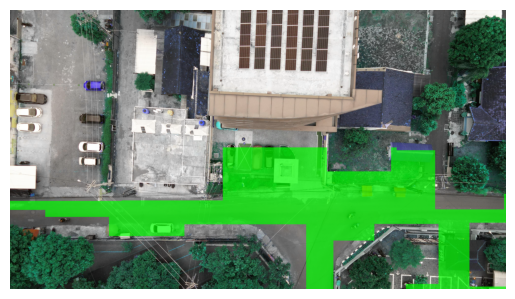

In [ ]:
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
